# **Landscape Analysis**

## **Import Dependencies**

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio as rio
from rasterio.windows import from_bounds
import pylandstats as pls
import os
from glob import glob
from tqdm import tqdm
from matplotlib.colors import ListedColormap, BoundaryNorm

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = 'Times New Roman'

data_dir = r"E:\HALDER\DATA\CORINE_LULC_1990_2018_DE"

## **Read the Datasets**

In [30]:
# Function to convert RGB to HEX
def rgb_to_hex(rgb):
    r, g, b = [int(i) for i in rgb.split('-')]
    return "#{:02X}{:02X}{:02X}".format(r, g, b)

In [88]:
# Define the file path
file_path = os.path.join(data_dir, "U2018_CLC2018_V2020_20u1", "U2018_CLC2018_V2020_20u1", "U2018_CLC2018_V2020_20u1.tif")
legend_path = os.path.join(data_dir, "U2018_CLC2018_V2020_20u1_raster100m_tiled_doc", "Info", "Legend", "Vector", "clc_legend.xls")

ls = pls.Landscape(file_path)

# Load class code, color, and label
legend_df = pd.read_excel(legend_path).dropna().iloc[:-1, :]
legend_df.rename(columns={'GRID_CODE': 'class_val'}, inplace=True)
legend_df['HEX'] = legend_df['RGB'].apply(lambda v: rgb_to_hex(v))

# Extract color list and class boundaries
colors = legend_df["HEX"].tolist()
classes = legend_df["class_val"].tolist()

# Create colormap and norm
cmap = ListedColormap(colors)
boundaries = classes + [classes[-1] + 1] 
norm = BoundaryNorm(boundaries, cmap.N)

print(legend_df.shape)
legend_df.head()

(44, 7)


,class_val,CLC_CODE,LABEL1,LABEL2,LABEL3,RGB,HEX
0,1,111,Artificial surfaces,Urban fabric,Continuous urban fabric,230-000-077,#E6004D
1,2,112,Artificial surfaces,Urban fabric,Discontinuous urban fabric,255-000-000,#FF0000
2,3,121,Artificial surfaces,"Industrial, commercial and transport units",Industrial or commercial units,204-077-242,#CC4DF2
3,4,122,Artificial surfaces,"Industrial, commercial and transport units",Road and rail networks and associated land,204-000-000,#CC0000
4,5,123,Artificial surfaces,"Industrial, commercial and transport units",Port areas,230-204-204,#E6CCCC


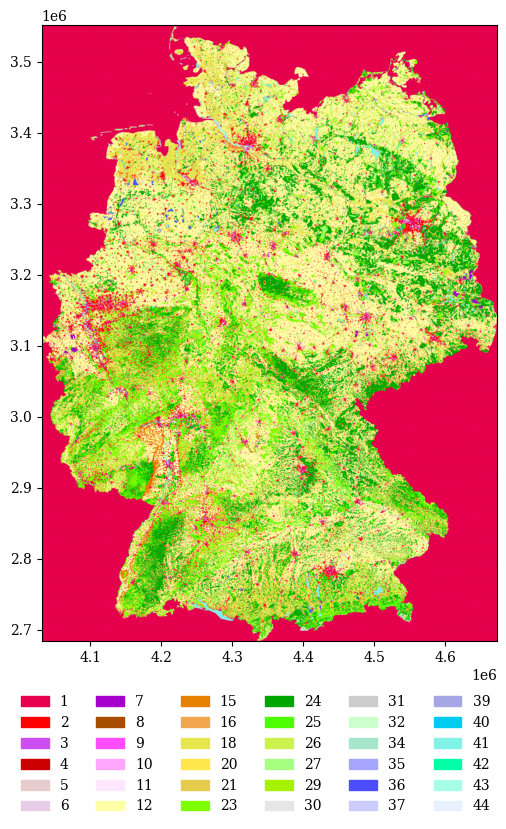

In [77]:
ax = ls.plot_landscape(
    cmap=cmap, norm=norm, legend=True, figsize=(8, 8), 
    legend_kwargs={'ncols': 6, 'loc': 'lower center', 'bbox_to_anchor':(0.22, -0.3, 0.5, 0.5),
                   'frameon': False}
);

## **Computing Metrics**

### **Patch-level Metrics**
**Patch-level metrics** are a category of landscape metrics that describe the characteristics of individual *patches* within a landscape.

**🟡 What is a Patch?**

In landscape ecology:

* A **patch** is a contiguous area of the same land use/land cover (LULC) class.
* For example, a group of connected forest pixels in a land cover raster forms a forest patch.

**🟡 What Are Patch-Level Metrics?**

Patch-level metrics quantify the **shape, size, and spatial properties** of each **individual patch** in the landscape.

Each patch is analyzed independently to compute values like:
* **`area`**: Total size of the patch (usually in hectares).
* **`perimeter`**: Length of the patch boundary (in meters).
* **`perimeter_area_ratio`**: Indicates shape compactness; higher means more irregular.
* **`shape_index`**: Measures deviation from a square shape; 1 is most compact.
* **`fractal_dimension`**: Reflects edge complexity; higher means more intricate shape.
* **`core_area`**: Inner patch area beyond a buffer zone from edges.
* **`number_of_core_areas`**: Count of distinct interior (core) zones within the patch.
* **`core_area_index`**: Percent of patch that qualifies as core (interior) area.
* **`euclidean_nearest_neighbor`**: Distance to the nearest patch of the same class.

Let me know if you want the same for class- or landscape-level metrics.


Each row in a patch-level DataFrame corresponds to a patch, with its LULC class and calculated metrics.

**🟡 Why Use Patch-Level Metrics?**

They are useful for:

* Understanding habitat fragmentation.
* Studying edge effects and patch isolation.
* Comparing shape complexity among different land cover types.
* Ecological modeling that depends on patch structure (e.g., species dispersal).

In [ ]:
# Compute the patch metrics
patch_metrics_df = ls.compute_patch_metrics_df(
    metrics=['area', 'perimeter', 'perimeter_area_ratio', 'shape_index', 'fractal_dimension',
             'core_area', 'number_of_core_areas', 'core_area_index'])
patch_metrics_df = patch_metrics_df.reset_index()
patch_metrics_df = pd.merge(left=patch_metrics_df, right=legend_df, on=['class_val'], how='left')
print(patch_metrics_df.shape)
patch_metrics_df.head()

(196796, 16)


,patch_id,class_val,area,perimeter,perimeter_area_ratio,shape_index,fractal_dimension,core_area,number_of_core_areas,core_area_index,CLC_CODE,LABEL1,LABEL2,LABEL3,RGB,HEX
0,0,1,68.0,4600.0,67.647059,1.352941,1.049530,37.0,1,54.411765,111,Artificial surfaces,Urban fabric,Continuous urban fabric,230-000-077,#E6004D
1,1,1,210.0,15400.0,73.333333,2.566667,1.134241,111.0,3,52.857143,111,Artificial surfaces,Urban fabric,Continuous urban fabric,230-000-077,#E6004D
2,2,1,28.0,3400.0,121.428571,1.545455,1.075577,8.0,1,28.571429,111,Artificial surfaces,Urban fabric,Continuous urban fabric,230-000-077,#E6004D
3,3,1,2.0,800.0,400.000000,1.333333,1.069990,0.0,0,0.000000,111,Artificial surfaces,Urban fabric,Continuous urban fabric,230-000-077,#E6004D
4,4,1,81.0,9400.0,116.049383,2.611111,1.141094,19.0,3,23.456790,111,Artificial surfaces,Urban fabric,Continuous urban fabric,230-000-077,#E6004D


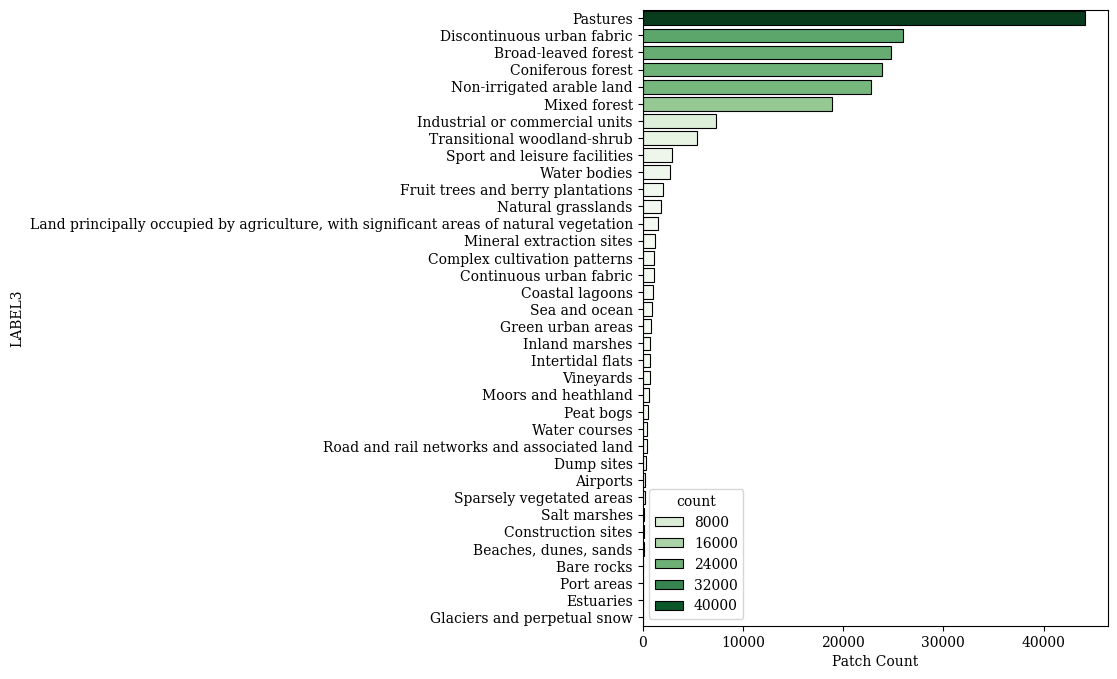

In [113]:
# Plot the patch count for all the classes
patch_count_per_class = patch_metrics_df['LABEL3'].value_counts()

plt.figure(figsize=(6, 8))
sns.barplot(x=patch_count_per_class, y=patch_count_per_class.index, hue=patch_count_per_class, 
            palette='Greens', edgecolor='k', linewidth=0.8)
plt.xlabel('Patch Count');